## Clustering Task 2 - GMM

0.055268049240112305
0.13936686515808105


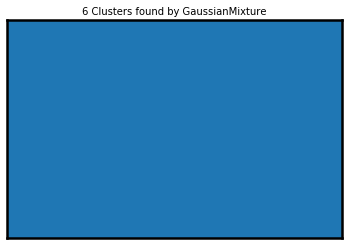

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
import sklearn.mixture as mixture

import sys
sys.path.append('../resources')
import w8support as w8s

# Make sure the pic subdirectory exists
import os, errno
try:
    os.makedirs('pic')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

%matplotlib inline

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 15, 'linewidths':0}
paletteName = 'deep'
fontSize = 10
fc = '#cccccc'

featureSub = pd.read_csv("oheTransformedData.csv")
nClusters = 6

from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(featureSub)
data.shape

# import originalFeatureSubset for use with label assignment
originalFeatureSubset = pd.read_csv("originalFeatureSubset.csv")

algName = "GaussianMixture"
for covType in ['spherical', 'full']:
    clusterParams = {'n_components':nClusters, 'covariance_type':covType, 'max_iter':100, 'random_state':0}
    start_time = time.time()
    gaussianMixture = mixture.GaussianMixture(**clusterParams)
    #print(dir(gaussianMixture))
    labels = gaussianMixture.fit(data).predict(data)
    
    # Add cluster labels to original dataframe for review and interpretation of cluster results.
    originalFeatureSubset['CLUSTERS'] = pd.Series(labels, index=originalFeatureSubset.index)
    
    # Subsequently, this will be invoked using a function call of the form
    # gaussianMixture, labels = w8s.fitClusterLabels(data, mixture.GaussianMixture, (), clusterParams)
    end_time = time.time()
    elapsed_time = end_time-start_time
    print(elapsed_time)
    #plt, elapsed_time = w8s.plot_clusters(data, mixture.GaussianMixture, (), clusterParams, plot_kwds)
    
    plt.clf() # Start new plot
    title = '{} Clusters found by {}'.format(str(nClusters),algName)
    plt = w8s.plot_2dClusters(data, labels, title, paletteName, fontSize, plot_kwds)
    outFile = 'pic/{}{}_{}_generated.pdf'.format(algName,str(nClusters),covType)
    plt.savefig(outFile)

    title = '{} Clusters (with regions) found by {}'.format(str(nClusters),algName)
    weights = gaussianMixture.weights_
    means = gaussianMixture.means_
    covariances = gaussianMixture.covariances_
    plt = w8s.overlayEllipses(plt, weights, means, covariances)
    outFile = 'pic/{}{}_{}_withEllipses_generated.pdf'.format(algName,str(nClusters),covType)
    plt.savefig(outFile)

In [11]:
# Check cluster column is present in dataframe.
originalFeatureSubset.head(5)

,who,Years_on_Internet,Web_Ordering,Age,Not_Purchasing_Too_complicated,Not_Purchasing_Prefer_people,Not_Purchasing_Privacy,Not_Purchasing_Security,Not_Purchasing_Easier_locally,CLUSTERS
0,93819,1-3_yr,Yes,41,0,0,0,0,0,1
1,95708,Under_6_mo,Yes,28,0,0,0,1,0,0
2,97218,1-3_yr,Yes,25,0,0,1,0,1,4
3,91627,1-3_yr,Yes,28,0,0,0,0,0,1
4,49906,1-3_yr,Yes,17,0,0,0,0,0,1


### Analyse GMM cluster groups
Now lets look at which features trend in to which clusters.

We will start with the boolean inputs:

In [12]:
for x in [0, 1, 2, 3, 4, 5]:
    for col in ['Not_Purchasing_Too_complicated', 'Not_Purchasing_Prefer_people','Not_Purchasing_Privacy', 'Not_Purchasing_Security', 'Not_Purchasing_Easier_locally']:
        clusterName = str(x)
        rowCount = str(len(originalFeatureSubset.loc[(originalFeatureSubset[col]) & (originalFeatureSubset.CLUSTERS == x)]))

        print('CLUSTER ' + clusterName + ' COUNT IS: ' + rowCount + ' for feature: ' + col)
    print('************************************************************')

CLUSTER 0 COUNT IS: 93 for feature: Not_Purchasing_Too_complicated
CLUSTER 0 COUNT IS: 238 for feature: Not_Purchasing_Prefer_people
CLUSTER 0 COUNT IS: 945 for feature: Not_Purchasing_Privacy
CLUSTER 0 COUNT IS: 1171 for feature: Not_Purchasing_Security
CLUSTER 0 COUNT IS: 312 for feature: Not_Purchasing_Easier_locally
************************************************************
CLUSTER 1 COUNT IS: 45 for feature: Not_Purchasing_Too_complicated
CLUSTER 1 COUNT IS: 0 for feature: Not_Purchasing_Prefer_people
CLUSTER 1 COUNT IS: 0 for feature: Not_Purchasing_Privacy
CLUSTER 1 COUNT IS: 0 for feature: Not_Purchasing_Security
CLUSTER 1 COUNT IS: 376 for feature: Not_Purchasing_Easier_locally
************************************************************
CLUSTER 2 COUNT IS: 46 for feature: Not_Purchasing_Too_complicated
CLUSTER 2 COUNT IS: 239 for feature: Not_Purchasing_Prefer_people
CLUSTER 2 COUNT IS: 568 for feature: Not_Purchasing_Privacy
CLUSTER 2 COUNT IS: 828 for feature: Not_Purchas

In [13]:
# We get the average age per cluster next to aid in the age exploration on this feature subset
originalFeatureSubset.groupby(['CLUSTERS'])['Age'].mean()

CLUSTERS
0    35.250578
1    34.804708
2    48.201022
3    22.690570
4    25.659853
5    51.871337
Name: Age, dtype: float64

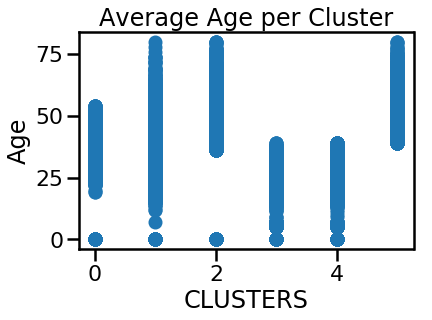

In [14]:
import matplotlib.pyplot as plt
plt.scatter(originalFeatureSubset['CLUSTERS'], originalFeatureSubset['Age'],)
plt.title("Average Age per Cluster")
plt.xlabel("CLUSTERS")
plt.ylabel("Age")
plt.show() # Depending on whether you use IPython or interactive mode, etc.

In [15]:
# Next we check the Years_on_Internet options in the dataset for use with grouping for the clusters
originalFeatureSubset.Years_on_Internet.unique()

array(['1-3_yr', 'Under_6_mo', '4-6_yr', '6-12_mo', 'Over_7_yr'],
      dtype=object)

In [16]:
# Next lets view results per cluster for most populate answer to Years_on_Internet
for x in [0, 1, 2, 3, 4, 5]:
    for result in ['1-3_yr', 'Under_6_mo', '4-6_yr', '6-12_mo', 'Over_7_yr']:
        clusterName = str(x)
        rowCount = str(len(originalFeatureSubset[originalFeatureSubset['Years_on_Internet'].str.contains(result) & (originalFeatureSubset.CLUSTERS == x)]))

        print('CLUSTER ' + clusterName + ' COUNT IS: ' + rowCount + ' for feature: ' + result + ' for Years_on_Internet')
    print('************************************************************')

CLUSTER 0 COUNT IS: 394 for feature: 1-3_yr for Years_on_Internet
CLUSTER 0 COUNT IS: 291 for feature: Under_6_mo for Years_on_Internet
CLUSTER 0 COUNT IS: 180 for feature: 4-6_yr for Years_on_Internet
CLUSTER 0 COUNT IS: 325 for feature: 6-12_mo for Years_on_Internet
CLUSTER 0 COUNT IS: 107 for feature: Over_7_yr for Years_on_Internet
************************************************************
CLUSTER 1 COUNT IS: 1427 for feature: 1-3_yr for Years_on_Internet
CLUSTER 1 COUNT IS: 0 for feature: Under_6_mo for Years_on_Internet
CLUSTER 1 COUNT IS: 867 for feature: 4-6_yr for Years_on_Internet
CLUSTER 1 COUNT IS: 0 for feature: 6-12_mo for Years_on_Internet
CLUSTER 1 COUNT IS: 0 for feature: Over_7_yr for Years_on_Internet
************************************************************
CLUSTER 2 COUNT IS: 287 for feature: 1-3_yr for Years_on_Internet
CLUSTER 2 COUNT IS: 445 for feature: Under_6_mo for Years_on_Internet
CLUSTER 2 COUNT IS: 67 for feature: 4-6_yr for Years_on_Internet
CLUSTE

In [17]:
# Next we double check the Web_Ordering options in the dataset are just Yes / No / Dont_know for use with grouping for the clusters
originalFeatureSubset.Web_Ordering.unique()

array(['Yes', 'No', 'Dont_know'], dtype=object)

In [18]:
# Next lets view results per cluster for most populate answer to Web Ordering
for x in [0, 1, 2, 3, 4, 5]:
    for result in ['Yes', 'No', 'Dont_know']:
        clusterName = str(x)
        rowCount = str(len(originalFeatureSubset[originalFeatureSubset['Web_Ordering'].str.contains(result) & (originalFeatureSubset.CLUSTERS == x)]))

        print('CLUSTER ' + clusterName + ' COUNT IS: ' + rowCount + ' for feature: ' + result + ' for Web_Ordering')
    print('************************************************************')

CLUSTER 0 COUNT IS: 1247 for feature: Yes for Web_Ordering
CLUSTER 0 COUNT IS: 23 for feature: No for Web_Ordering
CLUSTER 0 COUNT IS: 27 for feature: Dont_know for Web_Ordering
************************************************************
CLUSTER 1 COUNT IS: 2294 for feature: Yes for Web_Ordering
CLUSTER 1 COUNT IS: 0 for feature: No for Web_Ordering
CLUSTER 1 COUNT IS: 0 for feature: Dont_know for Web_Ordering
************************************************************
CLUSTER 2 COUNT IS: 1 for feature: Yes for Web_Ordering
CLUSTER 2 COUNT IS: 1170 for feature: No for Web_Ordering
CLUSTER 2 COUNT IS: 3 for feature: Dont_know for Web_Ordering
************************************************************
CLUSTER 3 COUNT IS: 53 for feature: Yes for Web_Ordering
CLUSTER 3 COUNT IS: 1960 for feature: No for Web_Ordering
CLUSTER 3 COUNT IS: 23 for feature: Dont_know for Web_Ordering
************************************************************
CLUSTER 4 COUNT IS: 1895 for feature: Yes for We

### GMM Results Summary for Clusters for Age Related Web Purchasing Features.
For each cluster I have taken the approach of pulling the largest values for each clusters based on what has been analysed above.

### cluster 0
* Average age of candidates for cluster 0 was 35.
* This candidates main concern for not purchasing something was Not_Purchasing_Security (1171).
* This candidates typical Years_on_Internet was 1-3_yr (394).
* Most answered Yes for Web_Ordering for this candidate (1247).

### cluster 1
* Average age of candidates for cluster 1 was 34.
* This candidates main concern for not purchasing something was Not_Purchasing_Easier_locally (376).
* This candidates typical Years_on_Internet was 1-3_yr (1427).
* Most answered Yes for Web_Ordering for this candidate (2294).

### cluster 2
* Average age of candidates for cluster 2 was 48.
* This candidates main concern for not purchasing something was Not_Purchasing_Security (828).
* This candidates typical Years_on_Internet was Under_6_mo (445).
* Most answered No for Web_Ordering for this candidate (1170).

### cluster 3
* Average age of candidates for cluster 3 was 22.
* This candidates main concern for not purchasing something was Not_Purchasing_Security (1066).
* This candidates typical Years_on_Internet was 1-3_yr (781).
* Most answered No for Web_Ordering for this candidate (1960).

### cluster 4
* Average age of candidates for cluster 4 was 25.
* This candidates main concern for not purchasing something was Not_Purchasing_Security (771).
* This candidates typical Years_on_Internet was 1-3_yr (599).
* Most answered Yes for Web_Ordering for this candidate (1895).

### cluster 5
* Average age of candidates for cluster 5 was 51.
* This candidates main concern for not purchasing something was Not_Purchasing_Security (536).
* This candidates typical Years_on_Internet was 6-12_mo (426).
* Most answered Yes for Web_Ordering for this candidate (1398).

## Advantages / Disadvantages of GMM for Internet Usage DataSet:

### Advantages	

* Ability to vary co-variance provides more flexibility. 
* It is a fast algorithm to use for comparing mixture models.
* Because the algorithm maximizes only the likelihood of a result, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.

### Disavantages
* Again, the user has to set the number of mixture models to perform on.
* From the resultset scatterplot, it is clear that struggles to get the boundaries correct. There is a lot of overlap. This nClusters was adjusted between 3, 4, 5 and 6 with little improvement on this, so 6 was chosen.
* From the results, k-means still looks clearer in terms of looking at clear cluster distances even though GMM is supposedly an improved version of k-means.
* Computation is known to not be as effective if dimensionality of the data is too high.

